# Introduction

This is another demo of ProCT.
Different from `demo.ipynb`, this version does not require torch-radon installed, and mainly shows how to use ProCT to infer on an image directly.

Let's first define some useful functions:

In [1]:
import os
import sys
sys.path.append('..')
import cv2
import math
import einops
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

def show_multiple_images(nrows, ncols, images, titles=None, tight=True, cmaps='gray', figsize=None, dpi=None, masks=None):
    num_imgs = len(images)
    num_plots = int(nrows * ncols)
    cmaps = [cmaps] * num_imgs if not isinstance(cmaps, (tuple, list)) else cmaps
    masks = [masks] * num_imgs if not isinstance(masks, (tuple, list)) else masks
    assert num_imgs <= num_plots, f'num_imgs = {num_imgs}, nrows = {nrows}, ncols = {ncols}.'
    fig, axes = plt.subplots(nrows, ncols, squeeze=False, figsize=figsize, dpi=dpi)
    axes = axes.flatten()
    for i in range(num_imgs):
        img = images[i].cpu().squeeze() if isinstance(images[i], torch.Tensor) else images[i].squeeze()
        mask = masks[i]
        if mask is not None:
            min_val = img.min()
            img[mask == 0] = min_val
        axes[i].imshow(img, cmap=cmaps[i])
        axes[i].axis('off')
        if titles is not None:
            axes[i].set_title(titles[i])
    
    if num_imgs < num_plots:
        for i in range(num_imgs, num_plots):
            axes[i].axis('off')
    if tight:
        fig.tight_layout()


def print_array_info(arr, output=False):
    shapes = []
    data_ranges = []
    if not isinstance(arr, (list, tuple)):
        arr = [arr]

    num_arrs = len(arr)
    for i in range(num_arrs):
        shape = tuple(arr[i].shape)
        data_range = (arr[i].min(), arr[i].max())
        if not output:
            print(f'Shape: {shape}, Range: {data_range}.')
        shapes.append(shape)
        data_ranges.append(data_range)

    if output:
        return shapes, data_ranges

/home/clma/miniconda3/envs/rec39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Preparing in-context pair

Load the pre-computed phantom pair from `phantom_dict.pkl`, which is a dictionary organized like this:
```python
phantom_dict = {
    'sparse_view': {
        18: 18-view CT image, in a 1x1x256x256 tensor, 
        36: 36-view CT image, in a 1x1x256x256 tensor, 
        72: 72-view CT image, in a 1x1x256x256 tensor, 
        144: 144-view CT image, in a 1x1x256x256 tensor, 
    },
    'limited_angle': {
        (0,60): 0°~60° limited-angle CT image, in a 1x1x256x256 tensor, 
        (0,90): 0°~90° limited-angle CT image, in a 1x1x256x256 tensor, 
        (0,120): 0°~120° limited-angle CT image, in a 1x1x256x256 tensor, 
        (0,150): 0°~150° limited-angle CT image, in a 1x1x256x256 tensor, 
    },
    'gt': full-view CT image, in a 1x1x256x256 tensor.
}
```

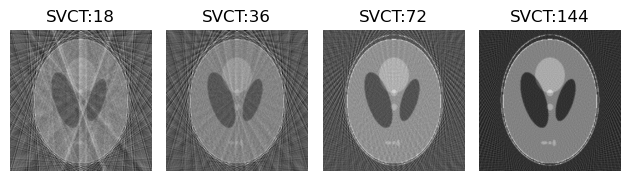

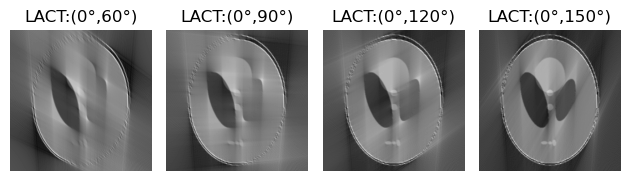

In [2]:
phantom_dict = torch.load('samples/phantom_dict.pkl', map_location='cpu')
show_multiple_images(
    1, 4, list(phantom_dict['sparse_view'].values()),
    titles=['SVCT:18', 'SVCT:36', 'SVCT:72', 'SVCT:144'])
show_multiple_images(
    1, 4, list(phantom_dict['limited_angle'].values()),
    titles=['LACT:(0°,60°)', 'LACT:(0°,90°)', 'LACT:(0°,120°)', 'LACT:(0°,150°)'])

# Preparing prompts

The view prompts are obtained from the incomplete-view sinogram mask. The code is a bit verbose but overall simple.

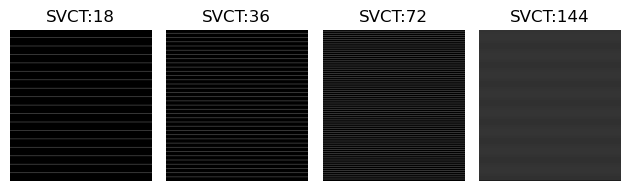

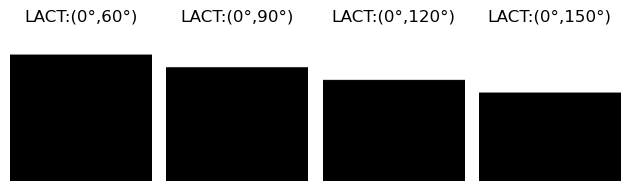

In [3]:
def get_angles(num_views, start_degree=None, end_degree=None):
    start_radian = start_degree / 180 * np.pi if start_degree is not None else 0
    end_radian = end_degree / 180 * np.pi if end_degree is not None else np.pi*2
    angles = np.linspace(start_radian, end_radian, num_views, endpoint=False)  # select views according to the specified number of views
    return angles

def get_sparse_view_mask(
    num_views, num_full_views=720, det_count=672, output_nchw=True, 
    start_view=None, end_view=None, num_avail_views=None):
    start_view = start_view if start_view is not None else 0
    end_view = end_view if end_view is not None else (num_full_views-1)
    num_avail_views = (end_view - start_view + 1) if num_avail_views is None else num_avail_views
    indices = np.arange(start_view+1, end_view+1+1)
    
    if num_views == num_full_views:
        bool_array = np.ones(num_full_views,)
    else:
        bool_array = np.zeros(num_full_views,)
        bool_array[indices-1] = np.ma.masked_equal((indices - start_view) % (num_avail_views//num_views), 1).mask  # shape:(num_full_views,)

    bool_array = torch.from_numpy(bool_array).float()
    bool_mask = bool_array.repeat(det_count, 1).permute(1, 0)
    if output_nchw:
        bool_mask = bool_mask.reshape(1, 1, *bool_mask.shape).contiguous()
    return bool_mask
        
def get_limited_angle_mask(angle_range, num_full_views=720, det_count=672):
    full_angles = get_angles(num_full_views)
    start_degree, end_degree = min(angle_range), max(angle_range)
    
    ratio = np.pi / 180
    min_val = start_degree * ratio
    max_val = end_degree * ratio
    bool_array = np.logical_and(full_angles >= min_val, full_angles <= max_val)

    bool_array = torch.from_numpy(bool_array).float()
    bool_mask = bool_array.repeat(det_count, 1).permute(1, 0)
    bool_mask = bool_mask.reshape(1, 1, *bool_mask.shape).contiguous()
    return bool_mask

def get_sino_mask(task_param, task='sparse_view'):
    if task == 'sparse_view':
        sino_mask = get_sparse_view_mask(task_param)
    elif task == 'limited_angle':
        sino_mask = get_limited_angle_mask(task_param)
    return sino_mask

def mask2prompt(sino_mask):
    return 1. - sino_mask[:, :, :, 0]

show_multiple_images(
    1, 4, [get_sino_mask(p, 'sparse_view') for p in (18, 36, 72, 144)],
    titles=['SVCT:18', 'SVCT:36', 'SVCT:72', 'SVCT:144'])
show_multiple_images(
    1, 4, [get_sino_mask((0,p), 'limited_angle') for p in (60,90,120,150)],
    titles=['LACT:(0°,60°)', 'LACT:(0°,90°)', 'LACT:(0°,120°)', 'LACT:(0°,150°)'])

# Preparing model

You may need to download the checkpoint first, and load the pretrained parameters into the model.

In [4]:
from sources.proct_wo_tr import ProCT

net_dict = dict(
    use_rope=False,
    block_kwargs={'norm_type':'INSTANCE'},
    drop_path_rates=0.1,
    use_spectrals=[True,True,True,False,False],
    use_learnable_prompt=False,
    num_heads=[2,4,6,1,1],
    attn_ratio=[0,1/2,1,0,0],
    num_full_views=720)
net = ProCT(1, 1, **net_dict)

ckpt_path = "/mnt/miah203/clma/off_the_shelf/proct/proct_v15.pkl"
net.load_state_dict(torch.load(ckpt_path, map_location='cpu')['network'])
net = net.cuda().eval()

/home/clma/miniconda3/envs/rec39/lib/python3.9/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646756402876/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Shape: (1, 1, 256, 256), Range: (tensor(-0.2300), tensor(0.6023)).
Shape: (1, 1, 256, 256), Range: (tensor(0.), tensor(0.5093)).
Shape: (1, 1, 2, 256, 256), Range: (tensor(-0.2580), tensor(0.6108)).
Shape: (1, 1, 720), Range: (tensor(0.), tensor(1.)).


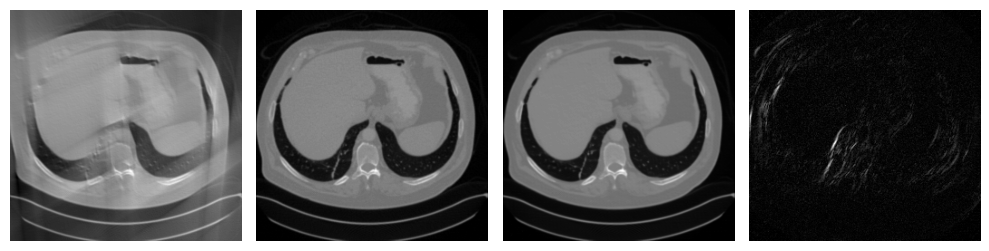

In [5]:
MIN_HU, MAX_HU = -1024, 3072
IMG_SIZE = (256, 256)

def normalize_hu(hu):
    return (hu - MIN_HU) / (MAX_HU - MIN_HU)

def _extract_task_and_param_from_path(path):
    name = path.split('/')[-1].replace('.npy', '')
    elems = name.split('_')
    task = elems[-2]
    task = 'sparse_view' if task == 'svct' else 'limited_angle'
    param = int(elems[-1])
    param = (0,param) if task == 'limited_angle' else param
    return task, param

img_path = 'samples/sample_2_lact_120.npy'
gt_path = 'samples/sample_2_gt.npy'
img = normalize_hu(torch.from_numpy(np.load(img_path)).float()).unsqueeze(0).unsqueeze(0)
gt = normalize_hu(torch.from_numpy(np.load(gt_path)).float()).unsqueeze(0).unsqueeze(0)
task, task_param = _extract_task_and_param_from_path(img_path)

# make in-context pair, with shape [batch_size, num_context, 2, height, width]
context = torch.cat(
    (phantom_dict[task][task_param], phantom_dict['gt']), 
    dim=1
).unsqueeze(1)  

# prepare prompt, with shape [batch_size, 1, num_full_views]
prompt = mask2prompt(get_sino_mask(task_param, task))

print_array_info([img, gt, context, prompt])

with torch.no_grad():
    pred = net(img.cuda(), context=context.cuda(), cond=prompt.cuda()).detach().clamp(0, 1)

err = torch.abs(pred - gt.cuda())
show_multiple_images(1, 4, [img, gt, pred, err], figsize=(10, 4))